In [19]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix, roc_curve

import sys
!{sys.executable} -m pip install --upgrade pip setuptools wheel
!{sys.executable} -m pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

RSEED = 42
np.random.seed(RSEED)


In [20]:
#1. Load dataset
df = pd.read_csv("C:\\Users\\User\\Desktop\\Assignments\\LAST SEM!!\\Machine Learning\\GiveMeSomeCredit\\cs-training.csv")   # <-- change path if needed

# Some versions of this dataset have an "Unnamed: 0" index column. Drop it.
if 'Unnamed: 0' in df.columns:
    df = df.rename(columns={'Unnamed: 0':'Id'}).drop(columns=['Id'])

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Columns with missing values (counts):


MonthlyIncome         29731
NumberOfDependents     3924
dtype: int64

Total columns with missing values: 2


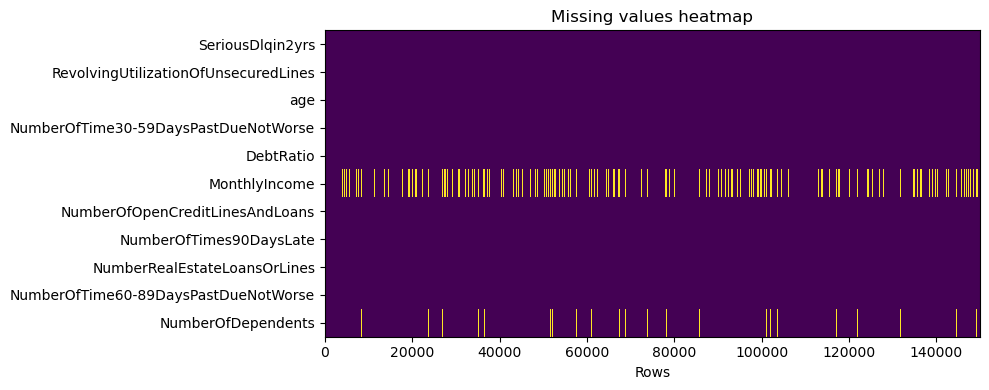

In [21]:
#2. Check Missing Values
missing_counts = df.isnull().sum()
missing = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("Columns with missing values (counts):")
display(missing)
print("Total columns with missing values:", len(missing))

# Visual heatmap of missingness (simple matplotlib image)
plt.figure(figsize=(10,4))
plt.imshow(df.isnull().T, aspect='auto', interpolation='nearest')
plt.yticks(range(len(df.columns)), df.columns)
plt.xlabel("Rows")
plt.title("Missing values heatmap")
plt.tight_layout()
plt.show()

In [22]:
#3. Imbalance handling show
target = "SeriousDlqin2yrs"
# drop possible index/ID columns if present
for col in ['Unnamed: 0', 'Id']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

print("Target present?:", target in df.columns)
print("Class distribution (counts and proportion):")
display(df[target].value_counts())
display(df[target].value_counts(normalize=True))


Target present?: True
Class distribution (counts and proportion):


SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64

In [23]:
#4. Feature select & train/test split
# Purpose: create X,y and split into train/test while preserving class ratios

X = df.drop(columns=[target])
y = df[target]

# basic column type split (for pipeline later)
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))
print("Sample numeric columns:", num_cols[:10])
print("Sample categorical columns:", cat_cols[:10])

# Stratified split to preserve class imbalance proportions
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RSEED
)
print("Train shape:", X_train_df.shape, "Test shape:", X_test_df.shape)

Numeric columns: 10
Categorical columns: 0
Sample numeric columns: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
Sample categorical columns: []
Train shape: (120000, 10) Test shape: (30000, 10)


In [24]:
#5. Preprocessing pipelines
# Purpose: impute numeric, scale, encode categorical, then transform train & test

# Numeric pipeline: median impute + standard scaling
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Categorical pipeline: mode impute + one-hot encode
cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

# Fit on training dataframe only (prevents leakage)
X_train = preprocessor.fit_transform(X_train_df)
X_test = preprocessor.transform(X_test_df)

print("Preprocessing complete.")
print("Transformed X_train shape:", X_train.shape)
print("Transformed X_test shape:", X_test.shape)

Preprocessing complete.
Transformed X_train shape: (120000, 10)
Transformed X_test shape: (30000, 10)


In [25]:
#6. SMOTE resampling for dataset
# Purpose: rebalance minority class on training data only (prevents test leakage)

sm = SMOTE(random_state=RSEED)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After SMOTE: X_train_sm shape:", X_train_sm.shape)
print("Class distribution after SMOTE (train):")
display(pd.Series(y_train_sm).value_counts(normalize=True))

After SMOTE: X_train_sm shape: (223958, 10)
Class distribution after SMOTE (train):


SeriousDlqin2yrs
0    0.5
1    0.5
Name: proportion, dtype: float64

In [26]:
#7. RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=RSEED, n_jobs=-1)
rf.fit(X_train_sm, y_train_sm)

# Predictions and probabilities on the held-out test set
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("RandomForest baseline — classification report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC (baseline RF):", roc_auc_score(y_test, y_proba_rf))

RandomForest baseline — classification report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     27995
           1       0.36      0.35      0.36      2005

    accuracy                           0.92     30000
   macro avg       0.66      0.65      0.66     30000
weighted avg       0.91      0.92      0.91     30000

ROC-AUC (baseline RF): 0.8262831223423849


In [27]:
#8. RandomForest tuning (GridSearchCV)
# Purpose: hyperparameter tuning (Task 1.6). Use small grid to keep runtime reasonable.

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

rf_gs = GridSearchCV(RandomForestClassifier(random_state=RSEED, n_jobs=-1),
                    rf_params,
                    cv=3,
                    scoring='f1', 
                    n_jobs=-1,
                    verbose=1)

# Fit on SMOTE-resampled training data
rf_gs.fit(X_train_sm, y_train_sm)

print("Best RF params:", rf_gs.best_params_)
rf_best = rf_gs.best_estimator_

# Evaluate tuned RF on test set
y_pred_rf_best = rf_best.predict(X_test)
y_proba_rf_best = rf_best.predict_proba(X_test)[:,1]
print("RandomForest (tuned) — classification report:")
print(classification_report(y_test, y_pred_rf_best))
print("RandomForest (tuned) ROC-AUC:", roc_auc_score(y_test, y_proba_rf_best))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest (tuned) — classification report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     27995
           1       0.36      0.35      0.36      2005

    accuracy                           0.92     30000
   macro avg       0.66      0.65      0.66     30000
weighted avg       0.91      0.92      0.91     30000

RandomForest (tuned) ROC-AUC: 0.8262831223423849


In [28]:
#9. ANN Calssifier
input_dim = X_train_sm.shape[1]

def build_ann_clf(input_dim, lr=1e-3):
    # Simple, reproducible ANN architecture for tabular data
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Manual small grid search (tuning lr and batch size)
ann_best = None
best_val = float('inf')
best_lr = None
best_batch = None

for lr in [1e-3, 5e-4]:
    for batch in [128, 256]:
        model = build_ann_clf(input_dim, lr=lr)
        es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
        history = model.fit(X_train_sm, y_train_sm, validation_split=0.15,
                            epochs=100, batch_size=batch, callbacks=[es], verbose=0)
        val_loss = min(history.history['val_loss'])
        print(f"ANN trial lr={lr}, batch={batch} -> best val_loss={val_loss:.6f}")
        if val_loss < best_val:
            best_val = val_loss
            ann_best = model
            best_lr = lr
            best_batch = batch

print("Selected ANN hyperparams -> lr:", best_lr, "batch:", best_batch, "val_loss:", best_val)

ANN trial lr=0.001, batch=128 -> best val_loss=0.390318
ANN trial lr=0.001, batch=256 -> best val_loss=0.401223
ANN trial lr=0.0005, batch=128 -> best val_loss=0.425353
ANN trial lr=0.0005, batch=256 -> best val_loss=0.397190
Selected ANN hyperparams -> lr: 0.001 batch: 128 val_loss: 0.3903177082538605


In [29]:
#10. Evaluate the ANN on dataset
# Purpose: classification report, ROC-AUC and probabilities

y_proba_ann = ann_best.predict(X_test).ravel()
y_pred_ann = (y_proba_ann >= 0.5).astype(int)

print("ANN — classification report:")
print(classification_report(y_test, y_pred_ann))
print("ANN ROC-AUC:", roc_auc_score(y_test, y_proba_ann))

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
ANN — classification report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.92     27995
           1       0.26      0.67      0.38      2005

    accuracy                           0.85     30000
   macro avg       0.62      0.77      0.65     30000
weighted avg       0.93      0.85      0.88     30000

ANN ROC-AUC: 0.8565441103438939


Model comparison:


,Accuracy,F1,ROC-AUC
RandomForest_Tuned,0.915833,0.355045,0.826283
ANN,0.851800,0.376612,0.856544


Best model by ROC-AUC: ANN


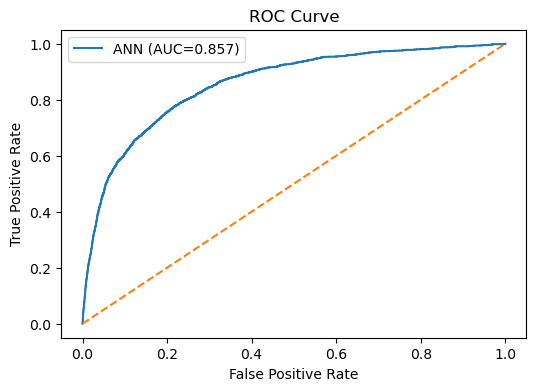

Confusion matrix (rows: true, cols: pred):


array([[24211,  3784],
       [  662,  1343]])

Top important features (RandomForest):


,feature,importance
4,MonthlyIncome,0.053547
3,DebtRatio,0.042347
6,NumberOfTimes90DaysLate,0.010510
8,NumberOfTime60-89DaysPastDueNotWorse,0.002197
2,NumberOfTime30-59DaysPastDueNotWorse,0.001847
9,NumberOfDependents,-0.000537
1,age,-0.002100
0,RevolvingUtilizationOfUnsecuredLines,-0.003003
5,NumberOfOpenCreditLinesAndLoans,-0.004470
7,NumberRealEstateLoansOrLines,-0.007403


In [30]:
#11 Compare models, ROC plot, confusion matrix and feature importance
# Metrics helper
def clf_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }

m_rf = clf_metrics(y_test, y_pred_rf_best, y_proba_rf_best)
m_ann = clf_metrics(y_test, y_pred_ann, y_proba_ann)

import pandas as pd
compare = pd.DataFrame([m_rf, m_ann], index=['RandomForest_Tuned','ANN'])
print("Model comparison:")
display(compare)

# ROC curve for the best by ROC-AUC
best = compare['ROC-AUC'].idxmax()
print("Best model by ROC-AUC:", best)
y_proba_best = y_proba_rf_best if best=='RandomForest_Tuned' else y_proba_ann

fpr, tpr, _ = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"{best} (AUC={compare.loc[best,'ROC-AUC']:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion matrix (threshold 0.5)
y_best_pred = (y_proba_best >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_best_pred)
print("Confusion matrix (rows: true, cols: pred):")
display(cm)

# Permutation importance for RandomForest (tuned) on the test set
perm = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=RSEED, n_jobs=-1)

# Map feature names back to columns (numeric + OHE names)
if len(cat_cols)>0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_ohe_names = ohe.get_feature_names_out(cat_cols)
    feature_names = num_cols + list(cat_ohe_names)
else:
    feature_names = num_cols

imp_df = pd.DataFrame({'feature': feature_names, 'importance': perm.importances_mean})
print("Top important features (RandomForest):")
display(imp_df.sort_values('importance', ascending=False).head(20))